# A demo of the parameter estimation of $g_d(x;\omega)$ and $p(E_y;\theta)$

In [5]:
import time    
from util import *
import numpy as np
import matplotlib.pyplot as plt

from jax import jit, vmap, tree_map, tree_multimap,value_and_grad, tree_leaves
from jax import lax, random, numpy as jnp
from jax.experimental import optimizers

from jax.config import config
config.enable_omnistaging() # Linen requires enabling omnistaging

import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from flax import optim

from typing import Any, Callable, Sequence, Optional

## Define a neural network

In [6]:
class BBNN(nn.Module):
  features: Sequence[int]

  def setup(self):
    # we automatically know what to do with lists, dicts of submodules
    self.layers = [nn.Dense(feat) for feat in self.features]

  def __call__(self, inputs):
    x = inputs
    for i, lyr in enumerate(self.layers):
      x = lyr(x)
      if i != len(self.layers) - 1:
        x = nn.relu(x)
    return x

## Define the loss function with the variance-based divergence measure

In [7]:
@jit
def pred_NN(params, X):
    return fmodel.apply(params, X.reshape(-1,1)).reshape(-1)

@jit
def weight_penalty(params, weight_decay = 0.0001):
    weight_penalty_params = tree_leaves(params)
    weight_l2 = sum([jnp.sum(x ** 2)
                    for x in weight_penalty_params
                    if x.ndim > 1])
    return weight_decay  * weight_l2
    
@jit
def otSort_NN(X,Y,param):
    """
    Sort effect variable based on the y - g(x)
    Return: the sorted y and x
    """
    Y_pred = pred_NN(param,X)
    Y_diff = Y-Y_pred 
    
    ind_sort = jnp.argsort(Y_diff, kind='quicksort')
    Y_diff_sorted = Y_diff[ind_sort]
    X_sorted = X[ind_sort]
    
    y = Y_diff_sorted
    x = X_sorted
    
    return y, x
    
@jit 
def loss_NN(params, df_batch, un, beta = 0.5,weight_decay = 0.0001):
    """
    loss function for vmap
    """
    x,y = df_batch[:,0],df_batch[:,1]
    batch_sz,_ = df_batch.shape
    y,x = otSort_NN(X=x,Y=y,param=params['NN'])
    noise = jnp.sort(params['thetaH']*un)
    vec = y - noise
    return jnp.var(vec) + beta * weight_penalty(params['NN'],weight_decay) 

## Loss function and gradient of w jit and vmap
val_loss_grad_NN = value_and_grad(loss_NN)
val_loss_grad_NN  = jit(val_loss_grad_NN)

## vmap version: val_grad_loss_jit
vmap_loss_grad_NN = vmap(val_loss_grad_NN, in_axes=(None,None,1,None, None),out_axes=0)  
vmap_loss_grad_NN = jit(vmap_loss_grad_NN)

## vmap version: when the batches have the same size, it can be vmapped ...
vmap_loss_grad_NN_inner = vmap(val_loss_grad_NN, in_axes=(None,None,1,None, None),out_axes=0)  
vmap_loss_grad_NN_outer = vmap(vmap_loss_grad_NN_inner, in_axes=(None,0,2,None, None),out_axes=0)  
vmap_loss_grad_NN_outer = jit(vmap_loss_grad_NN_outer)

## Generate synthetic data

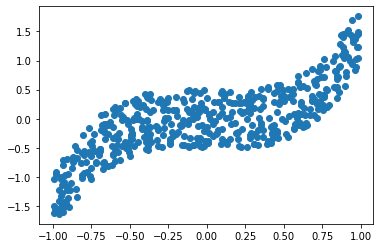

In [8]:
# Set problem dimensions
nsamples = 500
xdim = 1
ydim = 1
def f_t(x):
    return 0.1*((2.5*x)**3 - x)    
# Generate random ground truth W and b
key = random.PRNGKey(0)
k1, k2 = random.split(key)

# Generate samples with additional noise
ksample, knoise = random.split(k1)
x_samples = random.uniform(k1,shape=(nsamples, xdim),minval=-1, maxval=1)

y_samples = vmap(f_t)(x_samples)
y_samples += 0.5 * random.uniform(knoise,shape=(nsamples, ydim), minval=-1, maxval=1) # Adding noise
x,y = x_samples.reshape(-1),y_samples.reshape(-1)
n = nsamples

df_c = np.zeros([n,2])
df_c[:,0],df_c[:,1] = x,y
df_sort_c = sortBycol(df_c,0)

df_rv = np.zeros([n,2])
df_rv[:,0],df_rv[:,1] = y,x
df_sort_rv = sortBycol(df_rv,0)
plt.scatter(df_sort_c[:,0],df_sort_c[:,1])

## Create batches with the batch size $0.2$ and the number of positions $50$

In [10]:
resolution = 0.25
npos = 100
nghM = get_neighbor_matrix_fixed_num(df_sort_c, resolution)
batches = get_batches(data=df_sort_c, neighborM=nghM, resolution=resolution, npos=npos)
batches = jnp.array(batches)
df_batch = batches[0]
batch_sz,_ = df_batch.shape

## Optimize over the parameters of $p(E_y;\theta)$ and $g_d(x;\omega)$

In [11]:
key = random.PRNGKey(42)
key, subkey = random.split(key)

# Optimization parameters
beta = 0.01 # regularization term coefficent in the loss function
decay= 0.0001 # weight decay for training a neural network
nrep =100 # The number of repetition of sampling from p(Ey;theta)

# Define a neural network
fmodel = BBNN(features=[20,40,1])  # define a neural network
x = [0]
params_NN = fmodel.init(subkey, x)
theta_H =  2.0

# The parameters to optimize over
params = {'thetaH':theta_H,'NN':params_NN}

# Optimizer for training the neural network
optimizer_def = optim.RMSProp(learning_rate=0.05) # Choose the method
optimizer = optimizer_def.create(params) # Create the wrapping optimizer with initial parameters

for i in range(1000):
    key, subkey = random.split(key)
    un = random.uniform(subkey,shape=(batch_sz,nrep,len(batches)),minval=0.0, maxval=1.0)
    loss_val,grad = vmap_loss_grad_NN_outer(optimizer.target, batches, un,beta, decay)
    ave_loss,ave_grad = ave_loss_grad(loss_val,grad)
    optimizer = optimizer.apply_gradient(ave_grad) 
    if i % 50 == 0:
        print(i)
        
params_c = optimizer.target

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


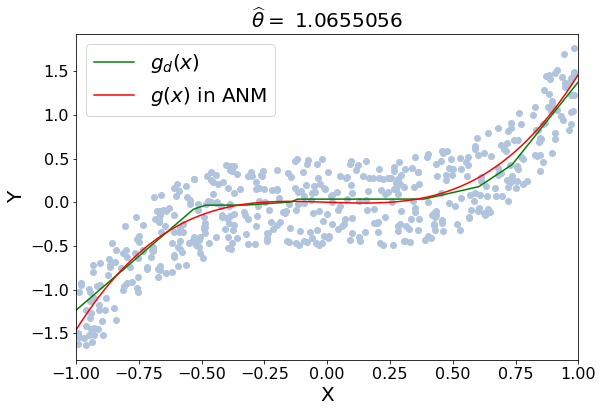

In [12]:
plt.figure(figsize=(9,6))
plt.xlim([-1,1])
plt.scatter(x_samples,y_samples,c='lightsteelblue')
x = jnp.arange(-1,1,0.001).reshape(-1,1)
y_bbnn = fmodel.apply(params_c['NN'], x)
plt.title('$\widehat{\\theta}=$ '+ str(params_c['thetaH'] ),fontsize=20)
plt.xlabel('X',fontsize=20)
plt.ylabel('Y',fontsize=20)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)

plt.plot(x,y_bbnn-jnp.mean(y_bbnn),color='green',label='$g_d(x)$')
plt.plot(x,f_t(x),color='r',label='$g(x)$ in ANM')
plt.legend(loc=0,fontsize=20)
# plt.savefig('syn4_1.pdf')

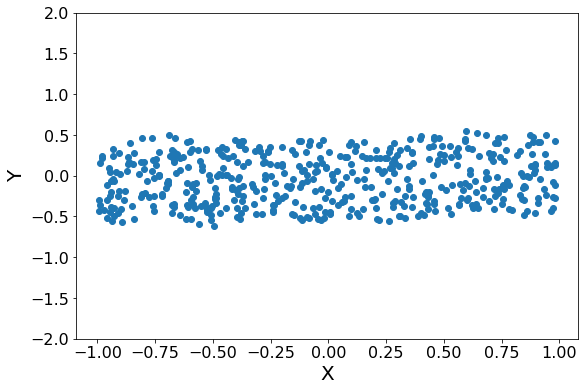

In [14]:
plt.figure(figsize=(9,6))
plt.xlabel('X',fontsize=20)
plt.ylabel('Y',fontsize=20)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)

plt.ylim([-2,2])
plt.scatter(x_samples,y_samples.reshape(-1,1)- fmodel.apply(optimizer.target['NN'], x_samples.reshape(-1,1)))
# plt.savefig('syn4_2.pdf')

# End